In [1]:
# Basic python import
import os
import sys
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Pytorch
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# Our custom module
sys.path.append('../')
import data_processing
import models
from evaluation import *
import submission

c:\Users\bapti\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

Ma proposition : 
Avoir un Notebook template associé à des paramètres par défaut. 
Ensuite pour chaque expérience on le duplique, et on change les valeurs des paramètres que l'on souhaite.

In [2]:
with open('../configs/default_params.yaml') as default_params_file:
      default_params = yaml.safe_load(default_params_file)
params = default_params
params

data_dir = os.path.join('..','data')

DEBUG = True

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [3]:
# Changer de paramètres
params["train"]["batch_size"] = 2
params["train"]

{'script_path': '../train/A_COMPLETER.py',
 'batch_size': 1,
 'epochs': 1000,
 'data_augmentation': {'samplewise_center': False,
  'samplewise_std_normalization': False,
  'rotation_range': 0,
  'width_shift_range': 0.1,
  'height_shift_range': 0.1,
  'horizontal_flip': True,
  'vertical_flip': False,
  'zoom_range': 0,
  'shear_range': 0,
  'channel_shift_range': 0,
  'featurewise_center': False,
  'zca_whitening': False}}

# Export masks as .tiff files

If it's the first time you run this notebook, you should uncomment the following cell and run it. It will read the masks from the .csv file and output them as .tiff files in a "train_masks" folder

In [4]:
#from data_processing.preproc import create_masks_as_tiff, preprocess_images_and_masks

# create_masks_as_tiff(data_dir)

# Create Dataset and Dataloader

In [5]:
from data_processing.utils import get_training_datasets_and_dataloaders
if DEBUG:
    train_dataset, validation_dataset, train_dataloader, validation_dataloader, encoder = get_training_datasets_and_dataloaders(batch_size=params["train"]["batch_size"] ,input_size=512, mode = 'debug')
else :
    train_dataset, validation_dataset, train_dataloader, validation_dataloader, encoder = get_training_datasets_and_dataloaders(batch_size=params["train"]["batch_size"] ,input_size=512)
#image, label, seg = train_dataset[0]
#print(image.shape)

# Train

In [6]:
from models.unet import UNet
#from models.segformer import SegFormer

MODEL = UNet(num_classes=1).to(device)

# segformer = SegFormer(
#     in_channels=3,
#     widths=[64, 128, 256, 512],
#     depths=[3, 4, 6, 3],
#     all_num_heads=[1, 2, 4, 8],
#     patch_sizes=[7, 3, 3, 3],
#     overlap_sizes=[4, 2, 2, 2],
#     reduction_ratios=[8, 4, 2, 1],
#     mlp_expansions=[4, 4, 4, 4],
#     decoder_channels=256,
#     scale_factors=[8, 4, 2, 1],
#     num_classes=1,
# )
#MODEL = segformer.to(device)

lr = 1e-4
optimizer = optim.Adam(MODEL.parameters(), lr=lr)
loss = nn.MSELoss()
o_classif_loss = nn.CrossEntropyLoss()
p_s_classif_loss = nn.MSELoss()

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [7]:
#MODEL = torch.load('../model_save/save_09_04_2023_09_27_53.pt')

In [8]:
from train.train import main_train, main_train_batch1

n_epochs = 100  # 25

if params["train"]["batch_size"] == 1:
    loss_list, o_classif_loss_list, p_s_classif_loss_list = main_train_batch1(model=MODEL.to(
        device), loss_fn=loss, o_classif_loss_fn=o_classif_loss, p_s_classif_loss_fn=p_s_classif_loss,  optimizer=optimizer, n_epochs=n_epochs, dataset=train_dataset, device=device)
if params["train"]["batch_size"] > 1:
    loss_list, o_classif_loss_list, p_s_classif_loss_list = main_train(model=MODEL.to(
        device), loss_fn=loss, o_classif_loss_fn=o_classif_loss, p_s_classif_loss_fn=p_s_classif_loss, optimizer=optimizer, n_epochs=n_epochs, dataloader=train_dataloader, device=device)

  0%|          | 0/11 [00:00<?, ?it/s]c:\Users\bapti\miniconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([1, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/11 [00:19<?, ?it/s]


ValueError: Expected input batch_size (1) to match target batch_size (5).

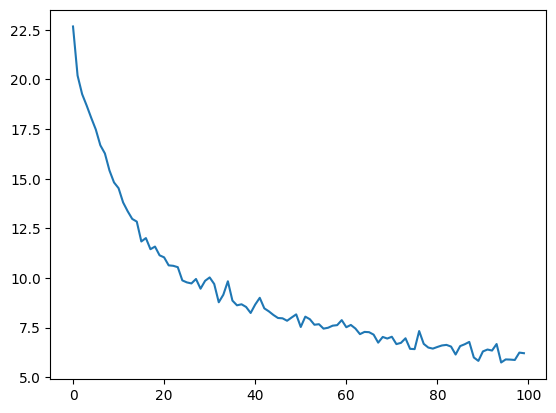

In [ ]:
plt.plot(loss_list)

In [ ]:
from torch.utils.data import Dataset


C:\Users\bapti\AppData\Local\Temp\ipykernel_2408\1705204230.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)
  ax[0].imshow(image.T)


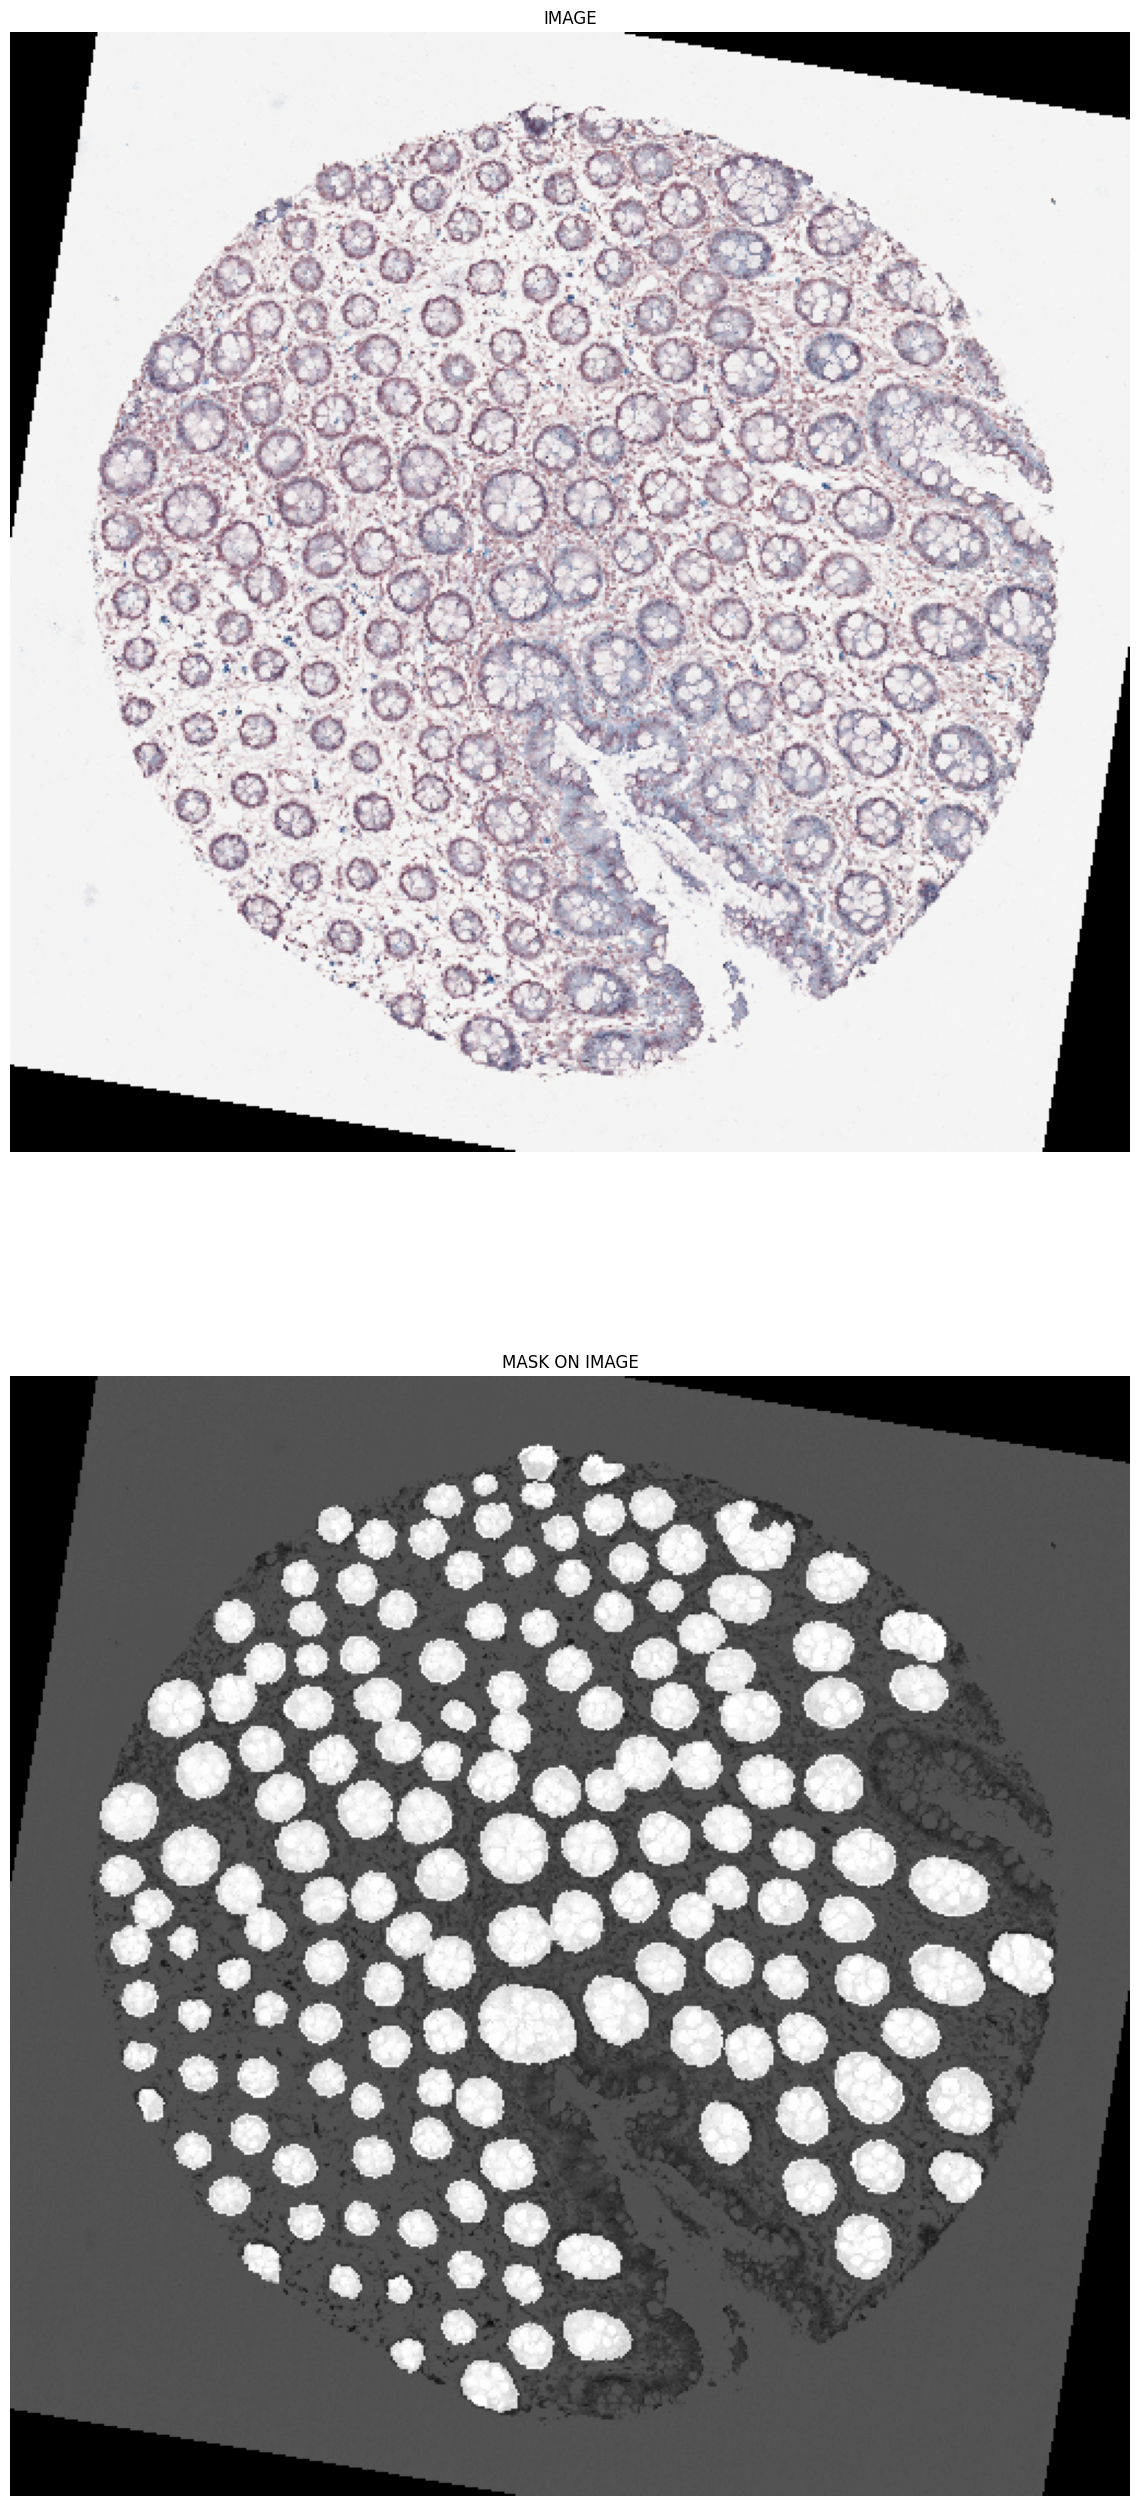

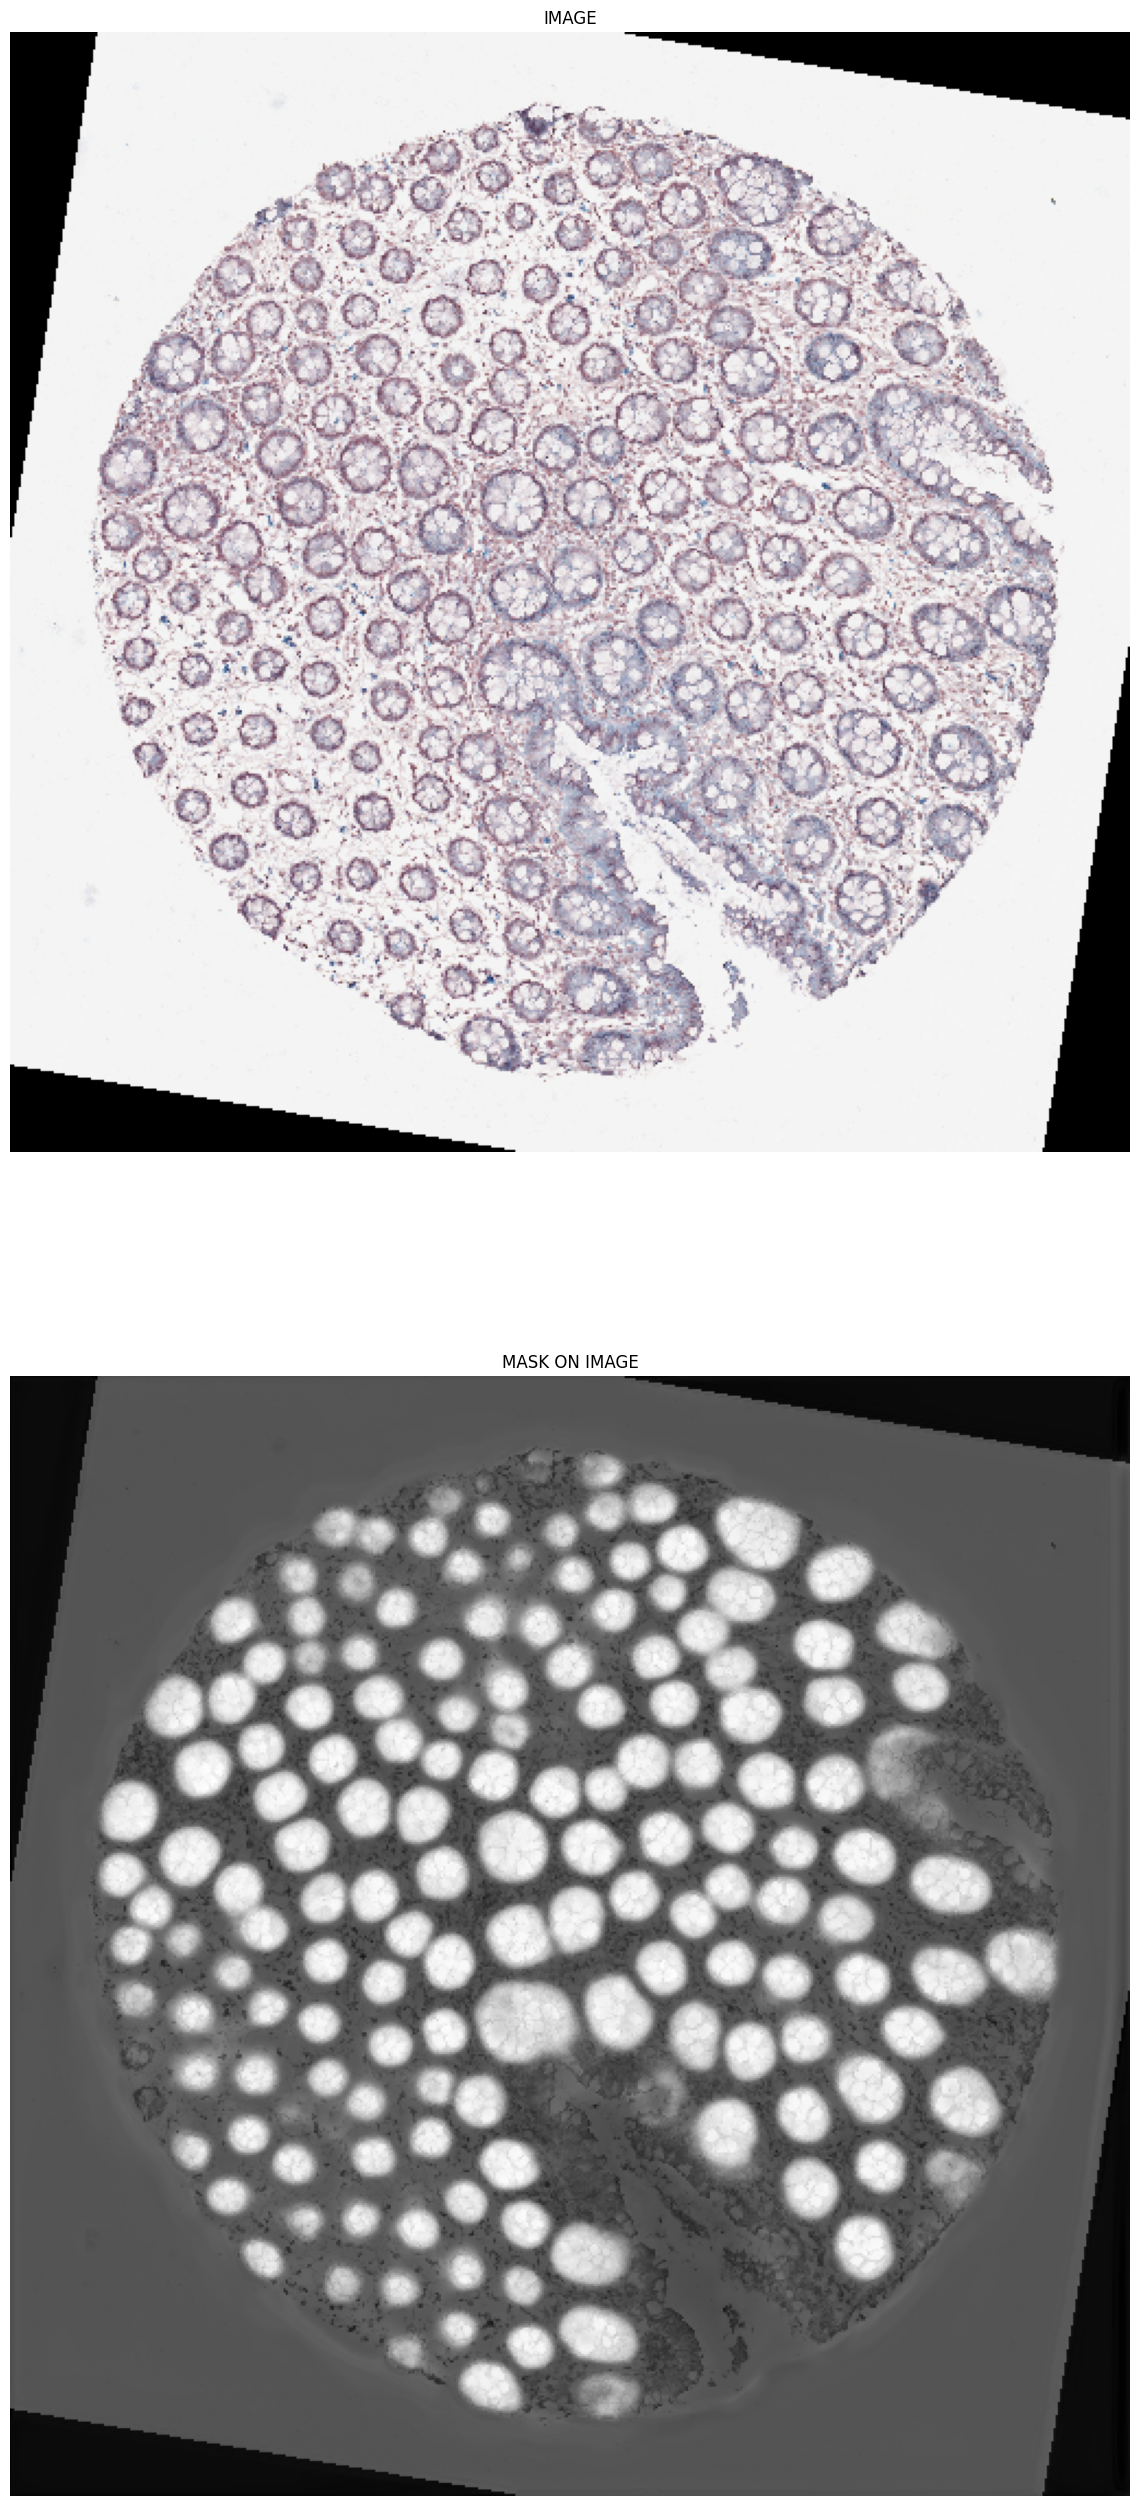

In [ ]:
def show_image_and_mask(image,mask,cmaps):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 32))
    hybr = image[0, :, :]/2 + mask[0, :, :]

    ax[0].imshow(image.T)
    ax[0].axis('off')
    ax[0].set_title('IMAGE')
    ax[1].imshow(hybr.T,cmap=cmaps)
    ax[1].axis('off')
    ax[1].set_title('MASK ON IMAGE')
    plt.show()

image, _, mask = train_dataset[0]

show_image_and_mask(image,mask,"gray")
show_image_and_mask(image,MODEL(torch.unsqueeze(image, dim=0).to(device)).cpu().detach(),"gray")

## Save model

In [ ]:
from datetime import datetime

torch.save(MODEL, f"../model_save/save_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.pt")

# Evaluation

Running model on validation dataset

In [ ]:
import gc
gc.collect()

10296

In [ ]:
# val_pred = {"val_images":[], "val_masks":[], "val_organs":[], "val_y_preds":[]}
# for k, (val_image, val_organ, val_mask) in enumerate(train_dl):
#     print(k)
#     val_pred['val_images'].append(val_image)
#     val_pred['val_masks'].append(val_mask)
#     val_pred['val_organs'].append(val_organ)

#     gc.collect()
#     print(torch.cuda.memory_allocated(0),
#         torch.cuda.memory_reserved(0),
#         torch.cuda.max_memory_reserved(0),)
#     pred = MODEL(val_image.to(device))
#     val_pred['val_y_preds'].append(pred.cpu)

In [ ]:
#Validation images, masks and organs
val_preds = {0:{"val_images":[], "val_masks":[], "val_organs":[], "val_y_preds":[]}} #Only 1 fold

for l, batch in enumerate(validation_dataset):
    (val_images, val_organs, val_masks) = batch
    val_mask_preds = MODEL(torch.unsqueeze(val_images, dim=0).to(device)).cpu().detach()
    #print(f'VAL_Y_PREDS shape: {val_mask_preds.shape}, VAL_Y_PREDS dtype: {val_mask_preds.dtype}')
    #print(f'val_images shape: {val_images.shape}, val_masks shape: {val_masks.shape}, val_organs shape: {len(val_organs)}')
    # Cast from Tensorflow to Numpy
    val_preds[0]['val_images'].append(val_images.numpy())
    val_preds[0]['val_masks'].append(val_masks.numpy().astype(np.uint8))
    val_preds[0]['val_organs'].append(val_organs)
    val_preds[0]['val_y_preds'].append(val_mask_preds[0].numpy())

In [ ]:
gc.collect()
print(torch.cuda.memory_allocated(0),
      torch.cuda.memory_reserved(0),
    torch.cuda.max_memory_reserved(0),)

132111360 1560281088 1560281088


In [ ]:
from evaluation.evaluation import get_y_true_y_pred

IoU_Folds = dict()
for fold, v in val_preds.items():
    IoUs, IoUsOrgans = get_y_true_y_pred(v)
    IoU_Folds[fold] = {
        'IoUs': IoUs,
        'IoUsOrgans': IoUsOrgans,
    }

<class 'tqdm.std.tqdm'>


  0%|          | 0/70 [00:00<?, ?it/s]

image shape: (3, 512, 512), y_true shape: (1, 512, 512)
organs: spleen, y_pred shape: (1, 512, 512)


100%|██████████| 70/70 [00:23<00:00,  3.02it/s]


FOLD 0


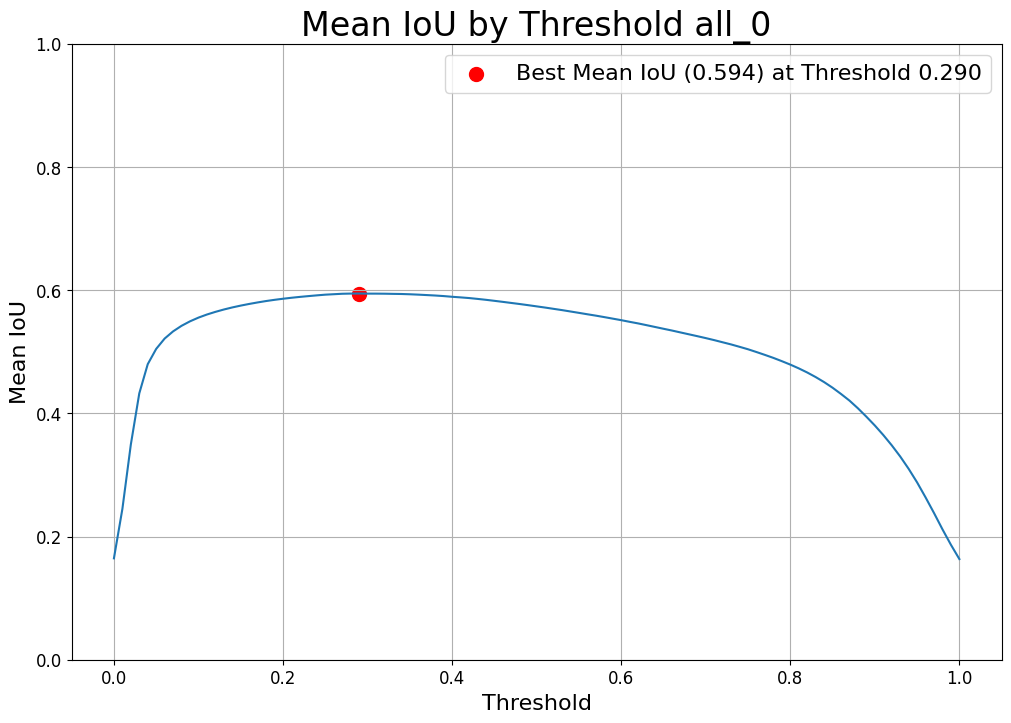

In [ ]:
from evaluation.evaluation import plot_iou_by_threshold

# Global Mean Intersection over Union at Threshold
for fold, v in IoU_Folds.items():
    print('=' * 80)
    print(f'FOLD {fold}')
    print('=' * 80)
    v['threshold_best'] = plot_iou_by_threshold(v['IoUs'], f'all_{fold}')

In [ ]:
for fold, v in IoU_Folds.items():
    print('=' * 80)
    print(f'FOLD {fold}')
    print('=' * 80)

    percentiles = [0.01, 0.05, 0.10, 0.25, 0.40, 0.50, 0.60, 0.75, 0.90, 0.95, 0.99]
    s = v['IoUs'][v['threshold_best']]

    display(pd.Series(s).describe(percentiles=percentiles).apply(lambda v: f'{v:.2f}').to_frame(name='Value').T)

FOLD 0


count  mean   std   min    1%    5%   10%   25%   40%   50%   60%  \
Value  70.00  0.59  0.26  0.00  0.00  0.09  0.13  0.43  0.65  0.71  0.72   

        75%   90%   95%   99%   max  
Value  0.79  0.83  0.86  0.91  0.92

FOLD 0


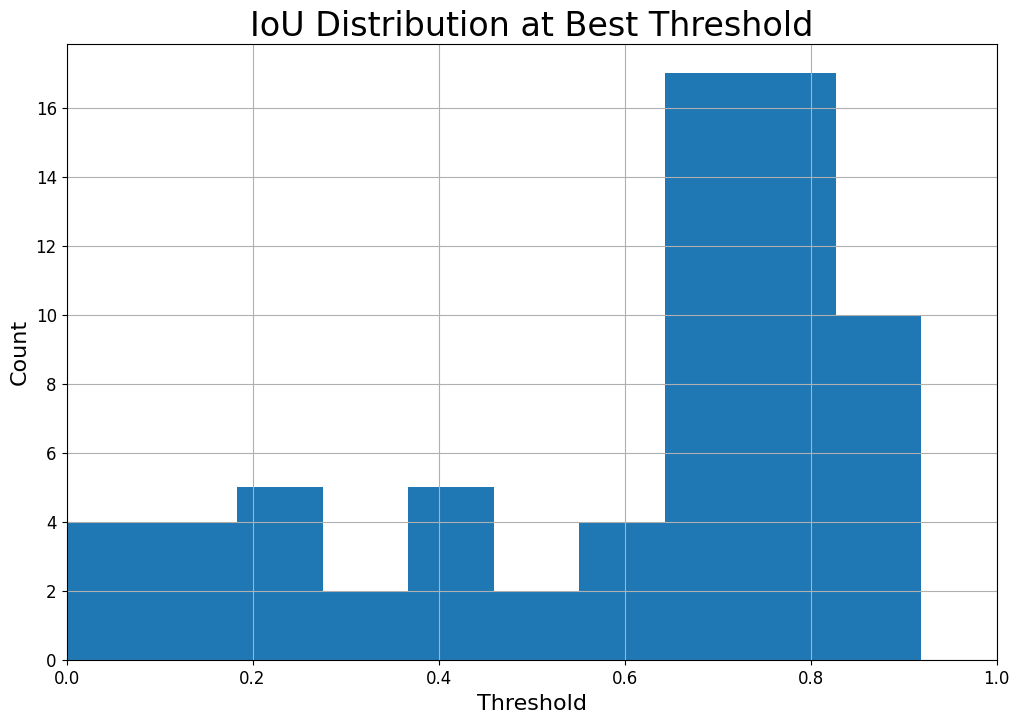

In [ ]:
for fold, v in IoU_Folds.items():
    print('=' * 80)
    print(f'FOLD {fold}')
    print('=' * 80)
    plt.figure(figsize=(12,8))
    pd.Series(v['IoUs'][v['threshold_best']]).plot(kind='hist')
    plt.title('IoU Distribution at Best Threshold', size=24)
    plt.grid()
    plt.xlabel('Threshold', size=16)
    plt.ylabel('Count', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlim(0,1)
    plt.show()

We can also look at some of the results

FOLD 0


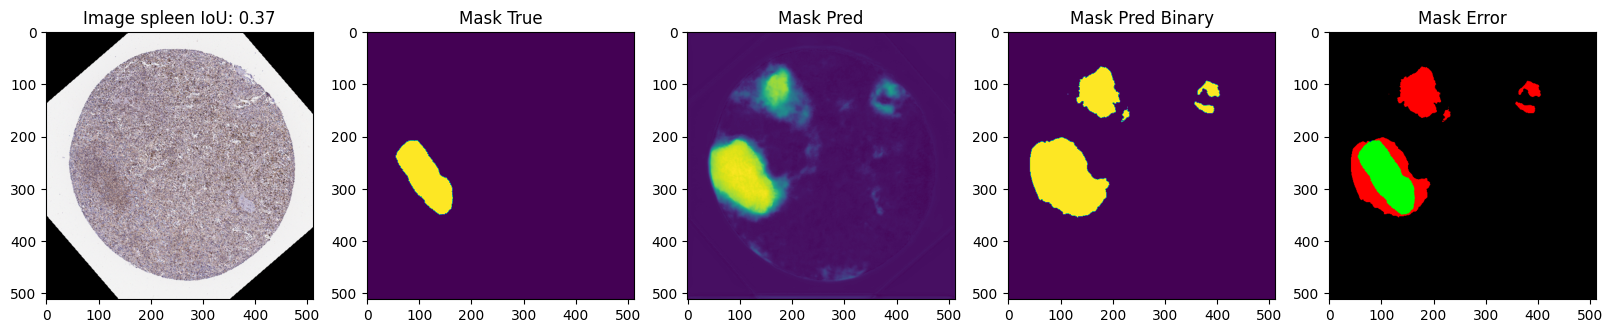

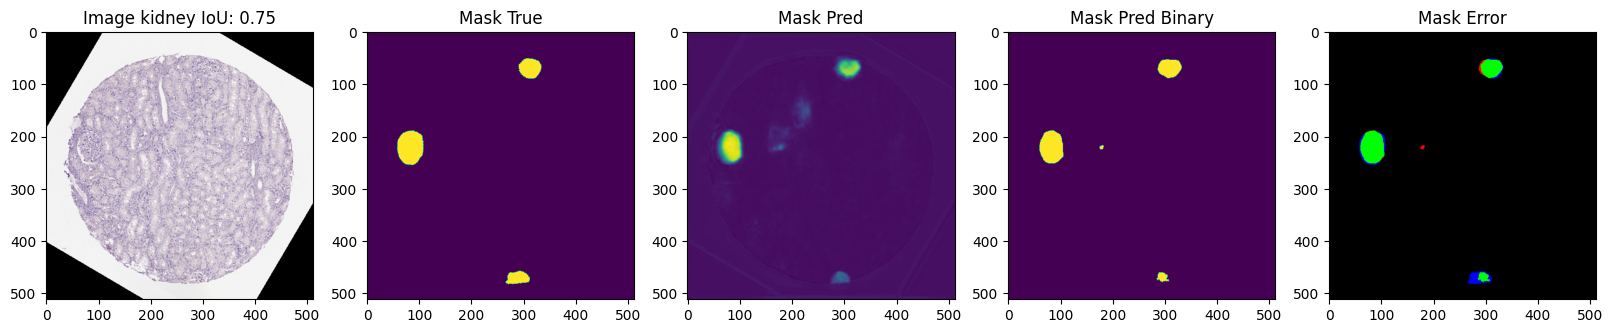

In [ ]:
from evaluation.evaluation import plot_validation_predictions

for fold, v in IoU_Folds.items():
    print('=' * 80)
    print(f'FOLD {fold}')
    print('=' * 80)
    threshold_best = IoU_Folds[fold]['threshold_best']
    plot_validation_predictions(val_preds[fold], threshold_best, 2, IoUs)

# Submission

In [ ]:
from submission import submission

test_dataset = None # TO BUILD
submission.make_submission(MODEL, test_dataset, threshold_best)

TypeError: make_submission() missing 2 required positional arguments: 'test_dataset' and 'threshold'